# 1. Data Pipeline

## Imports

In [1]:
!pip install numpy_financial

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None, 'display.max_columns', None)

import math
import scipy
import random

import time
import datetime as dt

import csv
import numpy_financial as npf

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [48]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.2.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Google Drive path
path = '/content/drive/My Drive/NYCDSA/lending_club/'  

Mounted at /content/drive


## Load accepted loans

In [3]:
tic = time.time()
source_df = pd.read_csv(path+'data/'+'datasets_902_370089_accepted_2007_to_2018Q4.csv.gz', 
                        compression='gzip')
print(f'Loaded in {time.time()-tic:.2f}')

Loaded in 54.17


In [4]:
df = source_df.copy()
df.shape

(2260701, 151)

In [5]:
# check the dtypes
# df.dtypes.reset_index()

In [6]:
# All member_id are NaN, depersonalized. URLs are useless, drop both
df.drop(['member_id', 'url'], inplace=True, axis=1)

# inspect the actual records
df.sample(3).T

,644008,467607,780561
id,112148543,128241364,139829878
loan_amnt,16000,28900,15000
funded_amnt,16000,28900,15000
funded_amnt_inv,16000,28900,15000
term,60 months,60 months,36 months
int_rate,15.05,9.93,6.67
installment,381.06,613.05,460.9
grade,C,B,A
sub_grade,C4,B2,A2
emp_title,Solution Architect,Lieutenant Fire Department,Engineer


'id' is an object b/c there are 33 'Subtotal' fields, which must be removed

In [7]:
# same 33 records have NaN 'term':
print(len(df[df.term.isna()]))
df[df.term.isna()].sample(2)

33


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1939380,Total amount funded in policy code 2: 81866225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1611877,Total amount funded in policy code 1: 2080429200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# remove these 33 records
df= df[~df.term.isna()]
df.shape

(2260668, 149)

## Select relevant fields

In the loan default/survival prediction context, select only features that are:
- known at loan origination
- static, i.e. are not updated later

Among the features we kept, there are a few that are clearly irrelevant to the prediction task ('member_id') but useful for reference purposes. There are some others such as 'zip_code' for which we decided to make a data-driven conclusion as opposed to pre-select.


Target for classification:
- loan_status

Targets for regression: survival time, realized return.  Necessary components:
- funded_amnt, total_pymnt, last_pymnt_d, recoveries

In [9]:
relevant_cols = [
# ------------ loan application and LC terms                 
    'id',        # reference purposes only
    'issue_d',   # reference purposes only

    'desc', # not a predictor, mapped to new var _has_desc
    'title', # not a predictor
    'application_type',   # binary  {'Individual':0, 'Joint App':1}
    'purpose',  # cardinal
    'grade',    # ordinal, map to N
    'sub_grade', # ordinal, map to N
    'term',      # binary  {'36 months':0, '60 months':1}
    'loan_amnt', # numeric
    'int_rate',  # numeric
    'installment',  # numeric
    'initial_list_status',  # binary  {'w':0, 'f':1}
    'disbursement_method',  # binary  {'Cash':0, 'DirectPay':1}

# ------------ borrower (self-declared except for verification status)
    'addr_state', # cardinal
    'zip_code',   # not a predictor, b/c 956 zip_codes, too granular
    'home_ownership',  # cardinal, leave 4 categories: MORTGAGE, RENT, OWN, OTHER(+ANY,+NONE)
    'emp_length', # ordinal, map to N
    'emp_title',  # not a predictor
    'annual_inc', # numeric
    'annual_inc_joint',  # not a predictor (mapped to annual_inc)
    'verification_status',  # ordinal: {'Not Verified':0, 'Source Verified':1, 'Verified':2}
    'verification_status_joint',  # not a predictor (mapped to verification_status)

# ------------ hard credit inquiry at origination
    'fico_range_high',  # remove. fico_high=fico_low+4 or, very rarely, fico_high=fico_low+5
    'fico_range_low',  # numeric
    'delinq_2yrs',# numeric
    'dti', # numeric
    'dti_joint',  # not a predictor (mapped to dti)
    'earliest_cr_line', # not a predictor (mapped to new var _credit_hist)
    'open_acc', # numeric
    'pub_rec', # numeric
    'revol_bal', # numeric
    'revol_util', # numeric

# ------------ targets / target components 
    'loan_status',
    'funded_amnt',
    'total_pymnt',  # includes recoveries
    'last_pymnt_d',
    'last_credit_pull_d', # proxy if last_pymnt_d is NaN
    'recoveries',
]

In [10]:
print(f'{len(relevant_cols)} features selected')

# new dataframe of features
df = df[relevant_cols]

39 features selected


## Targets, remove current

All LC loans eventually end up in 2 categories: Fully Paid and Charged Off.  Intermediate stages such as Current and Delinquent indicate recent loans which have not yet developed a target variable.

Remove all loans in the intermediate stages.  This will be applicable to both classification and regression.

In [11]:
# first analyze the distribution of outcomes
df.loan_status.value_counts(dropna=False, normalize=True)

Fully Paid                                             0.476298
Current                                                0.388521
Charged Off                                            0.118796
Late (31-120 days)                                     0.009496
In Grace Period                                        0.003732
Late (16-30 days)                                      0.001924
Does not meet the credit policy. Status:Fully Paid     0.000879
Does not meet the credit policy. Status:Charged Off    0.000337
Default                                                0.000018
Name: loan_status, dtype: float64

Leave: 
- Fully Paid
- Charged Off
- Default – added to Charged Off
- Does not meet the credit policy. Status:Fully Paid
- Does not meet the credit policy. Status:Charged Off

Remove:
- Current
- Late (31-120 days)
- Late (16-30 days)
- In Grace Period



In [12]:
remove_loans = ['Current','Late (31-120 days)','Late (16-30 days)','In Grace Period']
df = df[~df.loan_status.isin(remove_loans)]

df.shape

(1348099, 39)

In [13]:
df.loan_status.value_counts(dropna=False, normalize=True)

Fully Paid                                             0.798718
Charged Off                                            0.199213
Does not meet the credit policy. Status:Fully Paid     0.001475
Does not meet the credit policy. Status:Charged Off    0.000564
Default                                                0.000030
Name: loan_status, dtype: float64

### Classification target

In [14]:
# do not produce numpy targets yet b/c dataframe rows will be modified
good_loans = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
df['_good'] = df.loan_status.isin(good_loans).astype(int)

In [15]:
df._good.value_counts(dropna=False, normalize=True)

1    0.800193
0    0.199807
Name: _good, dtype: float64

### Regression target

In [16]:
# need to decide on how to calculate the duration & returns
# e.g. how to treat the opportunity cost

## Issue dates, remove pre-SEC

Lending Club registered its first prospectus with the SEC in October 2008. Assume consistent client onboarding and risk assessment started in January 2009, remove all earlier loans (0.22% of all loans). This will also take care of some of the missing data.

In [17]:
def make_dateval(s):
    return dt.datetime.strptime(s[-4:]+s[:3]+'01', '%Y%b%d')

In [18]:
df.issue_d = df.issue_d.apply(make_dateval)

In [19]:
# sort by issue date (to be used in the train/test split later on)
df.sort_values(by='issue_d', inplace=True)

# check the oldest and the newest issue dates
print(min(df.issue_d))
print(max(df.issue_d))

2007-06-01 00:00:00
2018-12-01 00:00:00


In [20]:
years = df.issue_d.apply(lambda x: x.year)
print(f'{100*np.mean(years<2009):.4f}% of loans issued before 2009')

0.2222% of loans issued before 2009


In [21]:
# remove the pre-SEC tail
df = df[years>=2009]
df.shape

(1345103, 40)

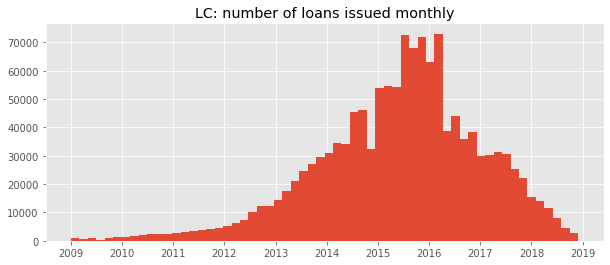

In [22]:
plt.figure(figsize=(10,4))
plt.hist(df.issue_d, bins=60)
plt.title('LC: number of loans issued monthly')
plt.show()

## Missing imputation

The nature of most missing data:
- missing joint application fields for indiv.app.
- missing optional textual descriptions/titles

In [23]:
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing>0].reset_index()
missing

,index,0
0,verification_status_joint,1319502
1,dti_joint,1319300
2,annual_inc_joint,1319297
3,desc,1222129
4,emp_title,85799
5,emp_length,78550
6,title,16660
7,last_pymnt_d,2322
8,revol_util,853
9,dti,374


In [24]:
# desc, emp_title, title
# all these strings are optional. Replace NaN with empty string
# these fields will NOT be treated as categorical (potentially, desc can be input for NLP)
# in contrast, 'purpose' is mandatory, has 14 fixed categories and will be dummified
df.desc.fillna('', inplace=True)
df.emp_title.fillna('', inplace=True)
df.title.fillna('', inplace=True)

In [25]:
# last_pymnt_d is missing only for charged-off and Late 31-120 
# However, 61% of such loans have non-zero total payments (recoveries)
# so there HAS to be a last payment date - important for return regression
# A simplifying assumption is made that in such case, last_pymnt_d ~ last_credit_pull_d

print(df[df.last_pymnt_d.isna()]['loan_status'].value_counts())
df.last_pymnt_d = np.where(df.last_pymnt_d.isna(), df.last_credit_pull_d, df.last_pymnt_d)

# convert date fields to datetime
df.last_pymnt_d = df.last_pymnt_d.apply(make_dateval)
df.earliest_cr_line = df.earliest_cr_line.apply(make_dateval)

Charged Off                                            2312
Does not meet the credit policy. Status:Charged Off      10
Name: loan_status, dtype: int64


In [26]:
# revol_util is NaN for many revol_bal=0 but not only
# assume that revol_util=0, basically unutilized revolving balance
df.revol_util.fillna(0, inplace=True)

In [27]:
# the only missing zip_code comes from AL, impute one of AL zip_codes
df.zip_code.fillna('355xx', inplace=True)

In [28]:
# Joint Applications
# when the loan is joint (legally, a joint obligation), the joint numbers supercede the single numbers :
#    dti_joint  --> if exists, replace dti  
#    annual_inc_joint --> if exists, replace annual_inc
#    verification_status_joint --> if exists AND is 'verified', replace verification_status 

df.dti = np.where(df.application_type=='Joint App', df.dti_joint, df.dti)
df.annual_inc = np.where(df.application_type=='Joint App', df.annual_inc_joint, df.annual_inc)
df.verification_status = np.where(df.verification_status_joint=='Verified', 
                                  df.verification_status_joint, df.verification_status)

# 3 loans have neither dti nor dti_joint, drop them
df[df.dti.isna()]
df = df[~df.dti.isna()]

In [29]:
df.emp_length.value_counts(dropna=False)

10+ years    442174
2 years      121732
< 1 year     107876
3 years      107613
1 year        88407
5 years       84185
4 years       80557
NaN           78550
6 years       62725
8 years       60704
7 years       59623
9 years       50954
Name: emp_length, dtype: int64

In [30]:
# For missing emp.length, assume it's roughly equivalent to years since earliest credit card
def distance_years(distance):
    if distance>=10:   return '10+ years'
    elif distance <1:  return '< 1 year'
    else:              return f'{int(distance)} years'

credit_history = np.round((df.issue_d - df.earliest_cr_line) / np.timedelta64(1,'Y'))
df.emp_length = np.where(df.emp_length.isna(), 
                         np.vectorize(distance_years)(credit_history), 
                         df.emp_length)

In [31]:
# drop the remaining columns with NaN which have been used to populate other fields
df.drop(['verification_status_joint', 'dti_joint', 'annual_inc_joint', 'last_credit_pull_d'], inplace=True, axis=1)

In [32]:
# verify there are no NaNs left
print(df.isna().sum().sum())
df.shape

0


(1345100, 36)

## Finalize dataframe

In [33]:
# create a new field 'has description' (proxy for extra transparency?)
df['_has_desc'] = np.vectorize(len)(df.desc)>0
df._has_desc = df._has_desc.astype(int)
# create a new field for credit history in Years
df['_credit_hist'] = credit_history

In [34]:
ordinal = [
    'application_type', 
    'grade',
    'sub_grade',
    'term',
    'initial_list_status',  # LC claims this is purely random: chi2 test!
    'emp_length',
    'verification_status',
    '_has_desc',
]

In [35]:
df.home_ownership.replace({'ANY':'OTHER', 'NONE':'OTHER'}, inplace=True)

nominal = [
  'purpose',
  'addr_state', # if linear models do not pick up this feature, revisit amd remove dummies (probably too much noise)
  'home_ownership',
  'disbursement_method', #highly imbalanced and probably irrelevant
]

In [36]:
numeric = [
    'loan_amnt', # numeric
    'int_rate',  # numeric
    'installment',  # numeric
    'annual_inc', # numeric
    'fico_range_low', 
    'delinq_2yrs',# numeric
    'dti', # numeric
    'open_acc', # numeric
    'pub_rec', # numeric
    'revol_bal', # numeric
    'revol_util', # numeric
    '_credit_hist', # new numeric
]
print(len(numeric))

12


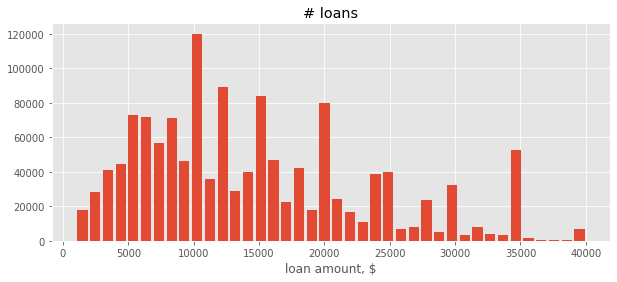

In [37]:
# explore the distribution of loan amount to decide whether to take a log
# conclusion: do not log b/c log_amount is left skewed (overcompensates)
# Spikes at ~round numbers (10K, 20K, 35K) suggest potential binning
plt.figure(figsize=(10,4))
plt.hist(df.loan_amnt, bins=40,rwidth=.8)
plt.xlabel('loan amount, $')
plt.title('# loans')
plt.show()

In [38]:
# check the integrity of numeric columns
for f in numeric:
    print(f'{f} \t{df[f].dtype} \t{df[f].isna().sum()}')

loan_amnt 	float64 	0
int_rate 	float64 	0
installment 	float64 	0
annual_inc 	float64 	0
fico_range_low 	float64 	0
delinq_2yrs 	float64 	0
dti 	float64 	0
open_acc 	float64 	0
pub_rec 	float64 	0
revol_bal 	float64 	0
revol_util 	float64 	0
_credit_hist 	float64 	0


In [39]:
# FREEZE THE DATAFRAME BEYOND THIS POINT
# convert 'id' to numeric and set as index 
df['id'] = df['id'].astype(int)
df.set_index('id', inplace=True)
print(df.shape)
df.sample(3).T

(1345100, 37)


id,129649014,867710,89010329
issue_d,2018-03-01 00:00:00,2011-09-01 00:00:00,2016-08-01 00:00:00
desc,,Borrower added on 08/20/11 > THIS LOAN IS TO...,
title,Credit card refinancing,LOAN CONSOLIDATION,
application_type,Joint App,Individual,Individual
purpose,credit_card,debt_consolidation,credit_card
grade,D,B,B
sub_grade,D1,B5,B5
term,60 months,60 months,36 months
loan_amnt,12800,35000,35000
int_rate,17.47,11.99,11.49


### Grades stats

In [40]:
grade_dict = {
'% Good': df.groupby('grade')._good.mean(),
'Loan Amount': df.groupby('grade').loan_amnt.mean(),
'FICO low': df.groupby('grade').fico_range_low.mean(),
'Ann.Income': df.groupby('grade').annual_inc.mean(),
'Int.Rate': df.groupby('grade').int_rate.mean(),
'DTI': df.groupby('grade').int_rate.mean(),
'Description': df.groupby('grade')._has_desc.mean(),
'Cred.History': df.groupby('grade').dti.mean(),
}


In [41]:
pd.DataFrame(grade_dict)

,% Good,Loan Amount,FICO low,Ann.Income,Int.Rate,DTI,Description,Cred.History
grade,,,,,,,,
A,0.939561,13902.309548,727.477033,89987.902905,7.111558,7.111558,0.102259,15.478891
B,0.866104,13240.684210,697.103035,77482.967200,10.679999,10.679999,0.105576,17.191322
C,0.775553,14190.182521,687.979389,73974.884125,14.023724,14.023724,0.077060,18.636687
D,0.696121,15265.555412,683.289889,71501.207396,17.722076,17.722076,0.081953,19.842614
E,0.615242,17602.201328,682.052352,73187.284693,21.133141,21.133141,0.079546,20.490151
F,0.548206,19071.472016,679.897023,74337.413608,24.920397,24.920397,0.102946,20.662194
G,0.501684,20525.738729,678.548615,78299.778136,27.669288,27.669288,0.094948,20.770961


# CF

Classify loans into three types:
- paid at maturity
- defaulted
- pre-paid

For each type, map loan --> {t,CF_t}. T has to be absolute time (123 monthly periods) 

Produce a master DF with cash flows for ALL loans, indexed by id (convert float64 into float32)

For an arbitary subset of ids, produce aggregate annualized IRR


## 1. Select relevant data

In [77]:
cf_cols = [
    '_good',
    'loan_status',
    'issue_d',   
    'loan_amnt', 
    'installment',
    'int_rate',  # for reference purposes
    'sub_grade', # for reference purposes  
    'term',
    'funded_amnt',
    'total_pymnt',
    'last_pymnt_d',
    'recoveries',
]

In [78]:
cf = df[cf_cols]
cf.head(2)

,_good,loan_status,issue_d,loan_amnt,installment,int_rate,sub_grade,term,funded_amnt,total_pymnt,last_pymnt_d,recoveries
id,,,,,,,,,,,,
372540,1,Fully Paid,2009-01-01,15000.0,502.00,12.53,C1,36 months,15000.0,16905.463474,2010-05-01,0.0
373376,1,Fully Paid,2009-01-01,5000.0,163.57,10.95,B1,36 months,5000.0,5776.951568,2011-03-01,0.0


### Loan life and Loan type

In [91]:
cf.shape

(1345100, 14)

In [79]:
cf['life'] = np.round((cf.last_pymnt_d - cf.issue_d) /np.timedelta64(1, 'M')).astype(int)

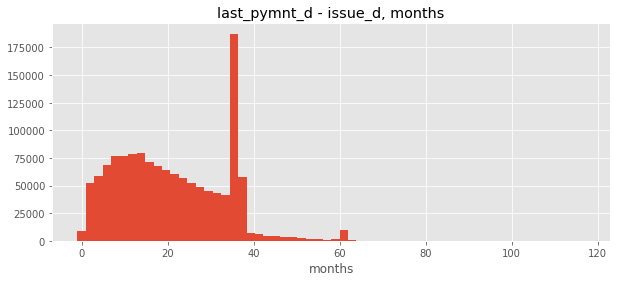

In [80]:
plt.figure(figsize=(10,4))
plt.hist(life, bins=60)
plt.title('last_pymnt_d - issue_d, months')
plt.xlabel('months')
plt.show()

In [81]:
# 0 and -1 life probably mean technical glitches, replace with life=1
cf.life[cf.life<=0].value_counts()

 0    9010
-1      23
Name: life, dtype: int64

In [82]:
cf['life'] = np.maximum(cf['life'], 1)

In [83]:
cf.term.replace({' 36 months':36, ' 60 months':60}, inplace=True)
cf['loan_type'] = cf.apply(lambda row: 'default' if (row._good==0) else\
                           'early' if (row.life<row.term) else 'normal', axis=1)

In [84]:
# 63% of the loans are paid early!
# many are pad back within a year - refinancing?
cf.loan_type.value_counts(normalize=True)

early      0.636352
default    0.199767
normal     0.163881
Name: loan_type, dtype: float64

## 2. CF for each loan

In [85]:
cf_dates = list(set(cf.issue_d) | set(cf.last_pymnt_d))
cf_dates.sort()
assert len(cf_dates)==123  # verify 123 monthly dates
cf_dates

[Timestamp('2009-01-01 00:00:00'),
 Timestamp('2009-02-01 00:00:00'),
 Timestamp('2009-03-01 00:00:00'),
 Timestamp('2009-04-01 00:00:00'),
 Timestamp('2009-05-01 00:00:00'),
 Timestamp('2009-06-01 00:00:00'),
 Timestamp('2009-07-01 00:00:00'),
 Timestamp('2009-08-01 00:00:00'),
 Timestamp('2009-09-01 00:00:00'),
 Timestamp('2009-10-01 00:00:00'),
 Timestamp('2009-11-01 00:00:00'),
 Timestamp('2009-12-01 00:00:00'),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2010-02-01 00:00:00'),
 Timestamp('2010-03-01 00:00:00'),
 Timestamp('2010-04-01 00:00:00'),
 Timestamp('2010-05-01 00:00:00'),
 Timestamp('2010-06-01 00:00:00'),
 Timestamp('2010-07-01 00:00:00'),
 Timestamp('2010-08-01 00:00:00'),
 Timestamp('2010-09-01 00:00:00'),
 Timestamp('2010-10-01 00:00:00'),
 Timestamp('2010-11-01 00:00:00'),
 Timestamp('2010-12-01 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2011-02-01 00:00:00'),
 Timestamp('2011-03-01 00:00:00'),
 Timestamp('2011-04-01 00:00:00'),
 Timestamp('2011-05-

In [86]:
def get_cfs(loan_id, recovery_lag=6):
    """produce the lifetime CF for 3 loan types:
        - early
        - normal (contractual)
        - default
    """
    loan_type, loan_amnt, installment, total_pymnt, recoveries, life, term = cf.loc[loan_id,\
    ['loan_type', 'loan_amnt', 'installment', 'total_pymnt', 'recoveries', 'life', 'term']]

    periods = len(cf_dates)
    # identify the issue_d column as a starting position for CFs
    start_period = cf_dates.index(cf.loc[loan_id, 'issue_d'])

    cfs = list(np.zeros(start_period)) + [-loan_amnt]
    
    if loan_type=='early':
        # assume regular installments and one lump sum at the end
        tail = total_pymnt - (life-1)*installment
        cfs += [installment for _ in range(life-1)] + [tail]

    if loan_type=='normal':  
        # some good loans last longer than term (~1-2 months)
        # but some others have final payment 6 months (and even 2 years) late
        # for such cases, assume regular installments for all but the last payment 
        tail = total_pymnt - (term-1)*installment
        cfs += [installment for _ in range(term-1)] + [0 for _ in range(life-term)] + [tail]

    if loan_type=='default':  
        # regular installments * life ALMOST always equals total_payments-recoveries
        # --> last_payment_d is NOT the recovery date, it's the last REGULAR payment date
        # i.e. regular installments are paid until last_payment_d, then stop
        # assume a recovery_lag time span to collect any recoveries
        
        norm_term = int((total_pymnt-recoveries) // installment)
        if norm_term>life:
            norm_term=int(life)
            installment=(total_pymnt-recoveries)/norm_term

        tail = (total_pymnt-recoveries) % installment

        cfs += [installment for _ in range(norm_term)]
        if len(cfs)<periods: 
            cfs += [tail]
        else:
            cfs[-1]+=tail

        if life>norm_term: 
            cfs += list(np.zeros(life-norm_term-1))

        if recoveries > 0:
            if periods-len(cfs)==0:
                cfs[-1]+=recoveries
            else:
                cfs += list(np.zeros(min(recovery_lag,periods-len(cfs))-1)) + [recoveries]


    assert len(cfs)<=periods
    # pad the cash flows to match the entire coverage period (123 months) 
    cfs = np.pad(cfs, (0, periods-len(cfs)))
    
    return cfs


In [87]:
# produce a CF file for specific loan_ids
# Master CF file is produced by setting loan_ids = cf.index

def write_cf_master(loan_ids):

    tic = time.time()
    output_file = f'cf_{int(time.time())}.csv'

    with open(path+f'cf/{output_file}', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(['id']+list(cf_dates)) # write headers

        for i, loan_id in enumerate(loan_ids):
            try:
                cfs = get_cfs(loan_id)
                assert len(cf_dates)==len(cfs)
                writer.writerow([loan_id]+list(cfs))
            except:
                print('ERROR. loan id:', loan_id)
            if (i+1)%1_000==0:
                print(f'\r{100*i/len(cf.index):.1f}% complete \t{time.time()-tic:.1f} sec', end='')

# write_cf_master(cf.index)

## 3. Randomized Return

In [88]:
# read Master CF file (740 Mb)
tic = time.time()
mf = pd.read_csv(path+'cf/'+'cf_master.csv')
mf.set_index('id',inplace=True)
print(f'loaded in {time.time()-tic:.1f} sec')

loaded in 19.6 sec


In [89]:
mf.head()

,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,2012-10-01 00:00:00,2012-11-01 00:00:00,2012-12-01 00:00:00,2013-01-01 00:00:00,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-04-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-07-01 00:00:00,2013-08-01 00:00:00,2013-09-01 00:00:00,2013-10-01 00:00:00,2013-11-01 00:00:00,2013-12-01 00:00:00,2014-01-01 00:00:00,2014-02-01 00:00:00,2014-03-01 00:00:00,2014-04-01 00:00:00,2014-05-01 00:00:00,2014-06-01 00:00:00,2014-07-01 00:00:00,2014-08-01 00:00:00,2014-09-01 00:00:00,2014-10-01 00:00:00,2014-11-01 00:00:00,2014-12-01 00:00:00,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,2015-07-01 00:00:00,2015-08-01 00:00:00,2015-09-01 00:00:00,2015-10-01 00:00:00,2015-11-01 00:00:00,2015-12-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00,2016-12-01 00:00:00,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
372540,-15000.0,502.00,502.00,502.00,502.00,502.00,502.00,502.00,502.00,502.00,502.00,502.00,502.00,502.00,502.00,502.00,9375.463474,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
373376,-5000.0,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.570000,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.57,163.57,1687.701568,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
371589,-4200.0,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.660000,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.66,138.660000,138.66,138.66,138.6

In [90]:
mf.shape

(1345100, 123)

In [95]:
def annualize_ret(monthly_ret):
    return (1+monthly_ret)**12-1
def portfolio_irr(loan_ids):
    monthly_irr =  npf.irr(mf.loc[loan_ids].apply(sum))
    return (1+monthly_irr)**12-1        

In [93]:
# Bootstrap: Sample N loans randomly for B times
# calculate the  IRR for the entire cash flow generated by the sample

B = 100
N = 1_000  # each time, sample N loans randomly

report_df = pd.DataFrame(columns=[f'mean_B{B}', f'std_B{B}'])
report_df

,mean_B100,std_B100


In [96]:
# calculate the randomized IRR for the entire loan universe
irrs = np.zeros(B)
for b in range(B):
    ids = random.sample(list(cf.index), 1_000)  
    irrs[b] = annualize_ret(npf.irr(mf.loc[ids].apply(sum)))  
total_irr, total_std = np.nanmean(irrs), np.nanstd(irrs)
total_irr, total_std

(0.02354691912352219, 0.009852026658284987)

In [97]:
# Calculate randomized IRRs within each sub_grade
sub_grades = sorted(list(set(cf.sub_grade)))
for sub_grade in sub_grades:
    
    loan_ids = cf[cf.sub_grade==sub_grade].index

    irrs = np.zeros(B)    
    for b in range(B):
        ids = random.sample(list(loan_ids), 1_000)  
        irrs[b] = annualize_ret(npf.irr(mf.loc[ids].apply(sum)))  
    
    report_df.loc[sub_grade] = [np.nanmean(irrs), np.nanstd(irrs)]
report_df    

,mean_B100,std_B100
A1,0.042144,0.003464
A2,0.045439,0.003778
A3,0.047124,0.004726
A4,0.046263,0.004114
A5,0.048147,0.004761
B1,0.042644,0.006083
B2,0.050907,0.006970
B3,0.049042,0.006632
B4,0.049040,0.008242
B5,0.037785,0.008296


In [98]:
def plot_irr_sub_grades(total_irr, total_std, report_df, B, N):
    plt.figure(figsize=(10,4))
    plt.axhline(total_irr, color='grey', label='sample from all grades')
    plt.fill_between(range(len(sub_grades)), 
                    total_irr-2*total_std, 
                    total_irr+2*total_std, color='grey', alpha=.2)
    irr_mean = report_df[f'mean_B{B}']
    irr_std  = report_df[f'std_B{B}']
    plt.plot(irr_mean, color='r', label='sample within subgrade')
    plt.fill_between(range(len(sub_grades)), 
                    irr_mean-2*irr_std, 
                    irr_mean+2*irr_std, color='red', alpha=.2)
    plt.xticks(range(len(sub_grades)))
    plt.title('Bootstrapped 1000 loans IRR')
    plt.legend(loc='lower left')
    plt.show()

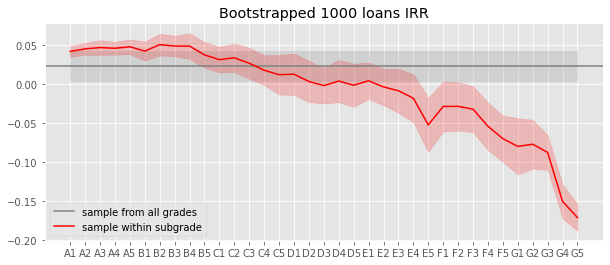

In [99]:
plot_irr_sub_grades(total_irr, total_std, report_df, B, N)